In [1]:
import numpy as np
from matplotlib import pyplot as plt


array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 1, 0]])


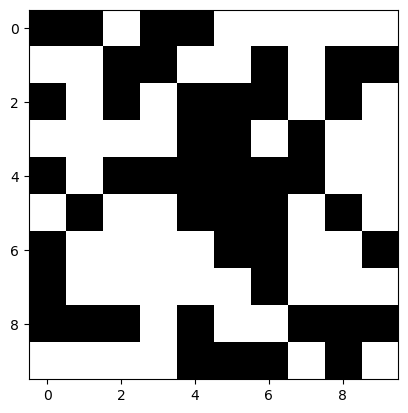

In [9]:
maze_size = (10, 10)  
maze_rand = np.random.choice([0, 1], size=maze_size)
print(repr(maze_rand))
plt.imshow(maze_rand, cmap='binary')
plt.show()

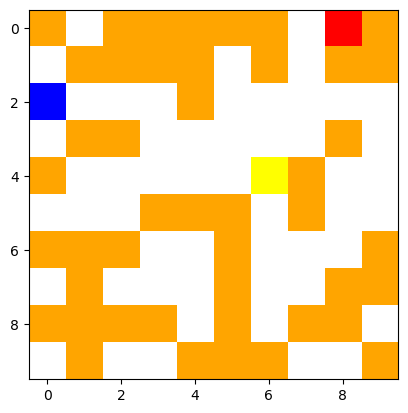

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (4, 6)]
(101, 4)
Q matrix: 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 

In [36]:
class Maze_env:
    def __init__(self , start, target, coins, maze):
        self.maze = maze
        self.target = target
        self.start = start
        self.coins = coins
        self.position = 0
        self.R = 0
        self.Q = 0
        self.states = []
        self.coin_collected = False
        
    def plot_env(self):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[self.start] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.show()
        
    def plot_env_position(self, position):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[position] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.show()

    def create_r_matrix(self):
        actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        num_states = self.maze.shape[0] * self.maze.shape[1]
        R = np.full((num_states, 4), np.nan)

        state_index = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
            # If the cell is not a wall
                if self.maze[i, j] == 0:
                    for index, action in enumerate(actions):
                        new_position = (i + action[0], j + action[1])
                        # If action leads to a valid state
                        if (0 <= new_position[0] < self.maze.shape[0] and
                            0 <= new_position[1] < self.maze.shape[1] and
                            self.maze[new_position] == 0):
                            # Calculate the state number for the new position
                            # Set reward to 0
                            R[state_index, index] = -5

                            # If action leads to goal state set reward to 100
                            if new_position == self.target:
                                R[state_index, index] = 1000
                            if new_position == self.coins:
                                R[state_index, index] = 200
                state_index += 1
                            
        self.R = R
        print(self.R.shape)
        return self.R
    
    def reward(self, state, action):
        state = self.states[state]
        x, y = state
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1
        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return -1  # hit a wall (including edges wall?)
        elif (x, y) == self.target:
            print("Reached Target!")
            print((x,y))
            
            return 1 + int(self.coin_collected == True) # reached the target and bonus if collected coin
        elif (x, y) == self.coins and not self.coin_collected:
            print("DING DING DING")
            return 2
        else:
            return -0.005  # regular step
        
    def transition(self, state, action):
        state_new = self.states[state]
        x, y = state_new
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return self.states.index(state_new)  # hit a wall, stay in the same state
        else:
            if (x, y) == self.coins and not self.coin_collected:
                print("Coin collected '{}'".format(self.coin_collected))
                self.coin_collected = True
                return 100 #specific index for coin
            else:
                return self.states.index((x,y))  # move to the new state
        
    
    def create_q_matrix(self):
        coord_to_index = []
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                coord_to_index.append((i,j))
        coord_to_index.append(self.coins)
        print(coord_to_index)
                
        num_states = self.maze.shape[0] * self.maze.shape[1] + 1
        num_actions = 4
        self.Q = np.zeros((num_states, num_actions))
        print(self.Q.shape)
        self.states = coord_to_index
        return self.Q, coord_to_index

maze = np.array([
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
                ])
# env = Maze_env((2,0),(0,8),(6,6), maze) 
env = Maze_env((2,0),(0,8),(4,6), maze) 
env.plot_env()
# R = env.create_r_matrix()
# print('R matrix: \n\n{}'.format(R))
Q, coord_to_index = env.create_q_matrix()
print('Q matrix: \n\n{}'.format(Q))




In [37]:
class Q_learning:
    
    def __init__(self, alpha, gamma, epsilon, episodes, steps, env, states):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = 1.0
        self.states = states

#         self.R = env.R
#         self.R_mod = self.R.copy()
        self.Q = env.Q
        self.episodes = episodes
        self.steps = steps
        self.start = env.start
        self.target = self.states.index(env.target)
        self.coins = env.coins
        self.env = env
        self.episodes_rewards = [] 
        print("Initial Q matrix is '{}'".format(self.Q))

    def plot_rewards(self):
        plt.plot(self.episodes_rewards)
        plt.show()
        
    def show_Q_spec(self,coord):
        print(q_learning.Q[self.states.index(coord)])
        
    def greedy_policy(self, state):
#                 available_actions = np.where(~np.isnan(self.R_mod[s]))[0]
#                 q_values = [self.Q[s,a] for a in available_actions]
#                 best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
        
        available_actions = np.array([0,1,2,3])
        q_values = [self.Q[state,a] for a in available_actions]
        best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]

        if np.random.uniform() < self.epsilon:
            a = np.random.choice(4)
#                     a = np.random.choice(available_actions)
        else:
#                     a = np.argmax(self.Q[s,:])
            a = np.random.choice(best_actions)
        return a
    
    def softmax_policy(self, state, temperature = 1.0):
        available_actions = np.array([0,1,2,3])
        q_values = np.array([self.Q[state,a] for a in available_actions])
        exp_values = np.exp(q_values / temperature)
        action_probs = exp_values / np.sum(exp_values)

        # Sample an action based on the probabilities
        selected_action = np.random.choice(len(action_probs), p=action_probs)
        return selected_action
        
    def train(self):
        print(self.states)
        print("Starting taget is '{}'".format(self.target))
        for episode in range(self.episodes):
            s = self.states.index(self.start)
            print("Starting state is '{}'".format(s))
            episode_reward = 0
            env.coin_collected = False
#             self.R_mod = self.R
            for timestep in range(self.steps):

                # Epsilon-greedy action choice
#                 a = self.greedy_policy(s)
                a = self.softmax_policy(s, self.temperature)

                # Environment updating
                r = env.reward(s, a)
#                 r = self.R_mod[s,a]
                episode_reward += r
                new_s = env.transition(s, a)
                # Doubts coordinates to Q system?
                # Q value updating
#                 print(new_s)
                self.Q[s,a] = self.Q[s,a] + self.alpha * ( r + self.gamma * np.max(self.Q[new_s,:]) - self.Q[s,a])

                if new_s == self.target:
                    break
                s = new_s
            
            self.episodes_rewards.append(episode_reward)
#             if episode % 2 == 0:
            if env.coin_collected:  
                print('Episode {} finished. Episode Reward {}.'.format(episode,episode_reward,))
            self.epsilon = max(self.epsilon*0.999,0.01)
            self.temperature = max(self.temperature*0.999,0.01)

            print(self.temperature)
            
    def test(self, limit):

        s = self.states.index(self.start)
        print("Starting state is '{}'".format(s))
        episode_reward = 0
        env.coin_collected = False
        for timestep in range(limit):
            self.env.plot_env_position(self.states[s])
            print(self.Q[s])
            a = np.argmax(self.Q[s])
            print(a)

            # Environment updating
            r = env.reward(s, a)
            print(r)
            episode_reward += r
            temp_new_s = env.transition(s, a)
#             new_s = self.states.index(temp_new_s)

            if temp_new_s == self.target:
                self.env.plot_env_position(self.states[temp_new_s])
                break
            s = temp_new_s
        print('Episode Reward {}.Q matrix values:\n{}'.format(episode_reward,self.Q.round(1)))


            

In [38]:
q_learning = Q_learning(1, 0.999, 1, 5000, 2000, env, coord_to_index)
q_learning.train()

Initial Q matrix is '[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

Episode 44 finished. Episode Reward -82.61999999999972.
0.9559759577813409
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 45 finished. Episode Reward -37.844999999999764.
0.9550199818235596
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 46 finished. Episode Reward -72.67000000000087.
0.9540649618417361
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 47 finished. Episode Reward -83.6149999999997.
0.9531108968798944
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 48 finished. Episode Reward -159.23499999999405.
0.9521577859830145
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 49 finished. Episode Reward -68.6900000000013.
0.9512056281970315
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 50 finished. Episode Reward -80.63000000000046.
0.9502544225688344
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 51 finished. Episode Reward -90.57999999

Episode 106 finished. Episode Reward -77.645000000001.
0.8984775710829266
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 107 finished. Episode Reward -119.43499999999493.
0.8975790935118436
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 108 finished. Episode Reward -40.83000000000106.
0.8966815144183318
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 109 finished. Episode Reward -46.80000000000077.
0.8957848329039134
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 110 finished. Episode Reward -48.79000000000149.
0.8948890480710096
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 111 finished. Episode Reward -85.60499999999982.
0.8939941590229386
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 112 finished. Episode Reward -72.6700000000007.
0.8931001648639156
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 113 finished. Episode Reward -55.75

Episode 167 finished. Episode Reward -77.64499999999997.
0.8452827805735033
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 168 finished. Episode Reward -76.64999999999917.
0.8444374977929298
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 169 finished. Episode Reward -56.7500000000021.
0.8435930602951368
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 170 finished. Episode Reward -70.68000000000167.
0.8427494672348417
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 171 finished. Episode Reward -69.68499999999963.
0.8419067177676068
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 172 finished. Episode Reward -69.68500000000104.
0.8410648110498392
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 173 finished. Episode Reward -61.725000000001394.
0.8402237462387894
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 174 finished. Episode Reward -68.

Episode 230 finished. Episode Reward -73.66500000000136.
0.7936477332643059
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 231 finished. Episode Reward -83.61500000000025.
0.7928540855310416
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 232 finished. Episode Reward -56.75000000000093.
0.7920612314455105
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 233 finished. Episode Reward -40.830000000000396.
0.7912691702140651
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 234 finished. Episode Reward -47.79500000000138.
0.790477901043851
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 235 finished. Episode Reward -67.6950000000017.
0.7896874231428072
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 236 finished. Episode Reward -84.6099999999991.
0.7888977357196644
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 237 finished. Episode Reward -81.62

Episode 291 finished. Episode Reward -25.904999999999905.
0.7466594429963713
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 292 finished. Episode Reward -37.844999999999544.
0.745912783553375
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 293 finished. Episode Reward -49.78500000000133.
0.7451668707698216
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 294 finished. Episode Reward -75.65500000000031.
0.7444217038990517
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 295 finished. Episode Reward -50.780000000001806.
0.7436772821951526
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 296 finished. Episode Reward -63.715000000001744.
0.7429336049129575
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 297 finished. Episode Reward -49.785000000001496.
0.7421906713080445
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 298 finished. Episode Reward 

Episode 351 finished. Episode Reward -53.765000000001535.
0.7031562730010349
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 352 finished. Episode Reward -80.6299999999991.
0.7024531167280339
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 353 finished. Episode Reward -51.77500000000222.
0.7017506636113059
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 354 finished. Episode Reward -45.805000000001314.
0.7010489129476946
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 355 finished. Episode Reward -53.76500000000089.
0.7003478640347469
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 356 finished. Episode Reward -48.79000000000062.
0.6996475161707122
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 357 finished. Episode Reward -54.76000000000167.
0.6989478686545415
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 358 finished. Episode Reward -50

Episode 411 finished. Episode Reward -53.76500000000202.
0.6621877602947683
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 412 finished. Episode Reward -48.79000000000155.
0.6615255725344735
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 413 finished. Episode Reward -66.70000000000188.
0.660864046961939
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 414 finished. Episode Reward -40.83000000000074.
0.660203182914977
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 415 finished. Episode Reward -57.74500000000263.
0.6595429797320621
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 416 finished. Episode Reward -61.72500000000191.
0.6588834367523301
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 417 finished. Episode Reward -37.845000000000205.
0.6582245533155777
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 418 finished. Episode Reward -55.7

Episode 473 finished. Episode Reward -51.77500000000092.
0.6223596374236124
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 474 finished. Episode Reward -34.85999999999963.
0.6217372777861888
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 475 finished. Episode Reward -25.904999999999585.
0.6211155405084027
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 476 finished. Episode Reward -43.81500000000112.
0.6204944249678943
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 477 finished. Episode Reward -53.765000000001535.
0.6198739305429264
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 478 finished. Episode Reward -32.87000000000006.
0.6192540566123834
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 479 finished. Episode Reward -52.77000000000115.
0.6186348025557711
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 480 finished. Episode Reward -5

Episode 535 finished. Episode Reward -43.815000000000396.
0.5849270275271061
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 536 finished. Episode Reward -46.80000000000118.
0.584342100499579
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 537 finished. Episode Reward -36.85000000000038.
0.5837577583990794
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 538 finished. Episode Reward -63.71500000000176.
0.5831740006406804
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 539 finished. Episode Reward -45.80500000000103.
0.5825908266400397
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 540 finished. Episode Reward -52.77000000000099.
0.5820082358133997
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 541 finished. Episode Reward -53.76500000000134.
0.5814262275775862
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 542 finished. Episode Reward -25.

Episode 598 finished. Episode Reward -44.810000000000656.
0.5491961035890855
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 599 finished. Episode Reward -51.77500000000166.
0.5486469074854965
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 600 finished. Episode Reward -39.835000000000946.
0.548098260578011
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 601 finished. Episode Reward -46.80000000000101.
0.547550162317433
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 602 finished. Episode Reward -43.81500000000077.
0.5470026121551156
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 603 finished. Episode Reward -47.795000000001636.
0.5464556095429605
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 604 finished. Episode Reward -25.905000000000097.
0.5459091539334175
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 605 finished. Episode Reward -2

Episode 659 finished. Episode Reward -55.75500000000153.
0.5166806879356919
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 660 finished. Episode Reward -39.83500000000064.
0.5161640072477562
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 661 finished. Episode Reward -32.87000000000013.
0.5156478432405085
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 662 finished. Episode Reward -19.935000000000024.
0.515132195397268
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 663 finished. Episode Reward -22.920000000000012.
0.5146170632018707
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 664 finished. Episode Reward -24.90999999999981.
0.5141024461386688
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 665 finished. Episode Reward -32.86999999999962.
0.5135883436925301
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 666 finished. Episode Reward -40

Episode 721 finished. Episode Reward -22.92000000000011.
0.48560427251675453
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 722 finished. Episode Reward -31.87499999999949.
0.48511866824423777
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 723 finished. Episode Reward -39.8350000000005.
0.4846335495759935
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 724 finished. Episode Reward -34.86000000000016.
0.4841489160264175
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 725 finished. Episode Reward -33.865.
0.4836647671103911
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 726 finished. Episode Reward -20.929999999999605.
0.4831811023432807
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 727 finished. Episode Reward -36.850000000000094.
0.4826979212409374
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 728 finished. Episode Reward -20.93000000

Episode 784 finished. Episode Reward -27.894999999999843.
0.45594059053811675
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 785 finished. Episode Reward -27.894999999999953.
0.45548464994757865
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 786 finished. Episode Reward -20.930000000000177.
0.45502916529763104
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 787 finished. Episode Reward -35.85499999999977.
0.45457413613233344
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 788 finished. Episode Reward -37.8450000000006.
0.4541195619962011
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 789 finished. Episode Reward -16.950000000000475.
0.4536654424342049
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 790 finished. Episode Reward -27.89499999999943.
0.45321177699177073
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 791 finished. Episode Rew

Episode 846 finished. Episode Reward -21.924999999999596.
0.42851746532991924
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 847 finished. Episode Reward -28.889999999999688.
0.42808894786458934
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 848 finished. Episode Reward -12.970000000000448.
0.42766085891672473
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 849 finished. Episode Reward -13.965000000000531.
0.427233198057808
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 850 finished. Episode Reward -42.82000000000056.
0.4268059648597502
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 851 finished. Episode Reward -9.985000000000161.
0.4263791588948904
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 852 finished. Episode Reward -12.970000000000407.
0.42595277973599555
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 853 finished. Episode Rew

Episode 908 finished. Episode Reward -20.929999999999687.
0.402743738775386
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 909 finished. Episode Reward -21.92500000000015.
0.4023409950366106
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 910 finished. Episode Reward -21.924999999999965.
0.401938654041574
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 911 finished. Episode Reward -25.904999999999493.
0.4015367153875324
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 912 finished. Episode Reward -18.939999999999902.
0.4011351786721449
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 913 finished. Episode Reward -15.955000000000679.
0.40073404349347275
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 914 finished. Episode Reward -27.894999999999662.
0.40033330944997925
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 915 finished. Episode Rewar

Episode 972 finished. Episode Reward -11.975000000000179.
0.3777635438089284
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 973 finished. Episode Reward -7.994999999999838.
0.3773857802651195
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 974 finished. Episode Reward -13.96500000000036.
0.37700839448485435
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 975 finished. Episode Reward -16.950000000000227.
0.3766313860903695
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 976 finished. Episode Reward -23.91499999999991.
0.37625475470427916
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 977 finished. Episode Reward -15.955000000000519.
0.3758784999495749
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 978 finished. Episode Reward -21.924999999999944.
0.3755026214496253
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 979 finished. Episode Rewar

Episode 1033 finished. Episode Reward -18.94000000000033.
0.35539787412304774
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1034 finished. Episode Reward -15.955000000000368.
0.3550424762489247
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1035 finished. Episode Reward -9.985000000000186.
0.3546874337726758
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1036 finished. Episode Reward -14.960000000000523.
0.35433274633890316
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1037 finished. Episode Reward -13.965000000000188.
0.35397841359256427
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1038 finished. Episode Reward -9.985000000000008.
0.3536244351789717
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1039 finished. Episode Reward -14.960000000000703.
0.35327081074379274
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1040 finished. Epi

Episode 1094 finished. Episode Reward -13.965000000000508.
0.33435637451312045
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1095 finished. Episode Reward -16.950000000000287.
0.3340220181386073
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1096 finished. Episode Reward -15.955000000000547.
0.33368799612046873
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1097 finished. Episode Reward -7.994999999999837.
0.33335430812434824
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1098 finished. Episode Reward -8.99.
0.3330209538162239
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1099 finished. Episode Reward -19.935000000000166.
0.33268793286240766
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1100 finished. Episode Reward -18.94000000000054.
0.33235524492954527
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1101 finished. Episode Reward 

Episode 1157 finished. Episode Reward -7.994999999999841.
0.31393184012901404
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1158 finished. Episode Reward -7.9949999999998385.
0.31361790828888503
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1159 finished. Episode Reward -7.994999999999836.
0.31330429038059615
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1160 finished. Episode Reward -10.980000000000341.
0.31299098609021553
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1161 finished. Episode Reward -7.994999999999834.
0.3126779951041253
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1162 finished. Episode Reward -8.989999999999835.
0.31236531710902116
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1163 finished. Episode Reward -7.994999999999835.
0.3120529517919121
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1164 finished. Epis

Episode 1218 finished. Episode Reward -7.994999999999837.
0.2953453567182228
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1219 finished. Episode Reward -14.960000000000466.
0.2950500113615046
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1220 finished. Episode Reward -8.989999999999927.
0.2947549613501431
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1221 finished. Episode Reward -7.994999999999835.
0.294460206388793
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1222 finished. Episode Reward -7.994999999999838.
0.2941657461824042
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1223 finished. Episode Reward -14.960000000000521.
0.2938715804362218
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1224 finished. Episode Reward -18.94000000000042.
0.2935777088557856
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1225 finished. Episode Re

Episode 1280 finished. Episode Reward -7.994999999999833.
0.27758143557361825
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1281 finished. Episode Reward -7.994999999999836.
0.27730385413804465
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1282 finished. Episode Reward -11.975000000000168.
0.2770265502839066
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1283 finished. Episode Reward -10.980000000000313.
0.2767495237336227
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1284 finished. Episode Reward -7.994999999999835.
0.2764727742098891
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1285 finished. Episode Reward -12.970000000000345.
0.2761963014356792
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1286 finished. Episode Reward -12.970000000000349.
0.27592010513424353
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1287 finished. Epis

Episode 1345 finished. Episode Reward -8.99000000000001.
0.2601040725539001
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1346 finished. Episode Reward -10.980000000000354.
0.2598439684813462
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1347 finished. Episode Reward -13.965000000000531.
0.2595841245128649
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1348 finished. Episode Reward -9.985000000000012.
0.259324540388352
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1349 finished. Episode Reward -11.97500000000001.
0.25906521584796366
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1350 finished. Episode Reward -19.935000000000173.
0.2588061506321157
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1351 finished. Episode Reward -23.914999999999694.
0.2585473444814836
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1352 finished. Episode 

Episode 1408 finished. Episode Reward -7.994999999999833.
0.24421532336806764
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1409 finished. Episode Reward -7.994999999999834.
0.24397110804469957
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1410 finished. Episode Reward -7.994999999999833.
0.24372713693665488
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1411 finished. Episode Reward -7.994999999999834.
0.24348340979971822
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1412 finished. Episode Reward -7.994999999999838.
0.2432399263899185
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1413 finished. Episode Reward -7.994999999999833.
0.2429966864635286
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1414 finished. Episode Reward -7.9949999999998385.
0.24275368977706507
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1415 finished. Episo

Episode 1467 finished. Episode Reward -7.994999999999835.
0.23021664244871493
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1468 finished. Episode Reward -8.990000000000009.
0.22998642580626621
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1469 finished. Episode Reward -8.989999999999988.
0.22975643938045995
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1470 finished. Episode Reward -7.994999999999836.
0.2295266829410795
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1471 finished. Episode Reward -7.994999999999834.
0.22929715625813843
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1472 finished. Episode Reward -7.994999999999836.
0.2290678591018803
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1473 finished. Episode Reward -7.994999999999835.
0.22883879124277842
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1474 finished. Episod

Episode 1530 finished. Episode Reward -15.955000000000684.
0.21615360047341434
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1531 finished. Episode Reward -12.970000000000338.
0.21593744687294092
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1532 finished. Episode Reward -8.990000000000016.
0.21572150942606796
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1533 finished. Episode Reward -16.950000000000514.
0.2155057879166419
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1534 finished. Episode Reward -10.980000000000254.
0.21529028212872525
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1535 finished. Episode Reward -7.994999999999834.
0.21507499184659654
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1536 finished. Episode Reward -7.994999999999833.
0.21485991685474995
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1537 finished. E

Episode 1590 finished. Episode Reward -10.980000000000183.
0.2035596837759133
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1591 finished. Episode Reward -12.970000000000484.
0.20335612409213738
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1592 finished. Episode Reward -15.955000000000524.
0.20315276796804524
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1593 finished. Episode Reward -18.940000000000186.
0.2029496152000772
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1594 finished. Episode Reward -19.93500000000031.
0.20274666558487714
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1595 finished. Episode Reward -19.935000000000286.
0.20254391891929227
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1596 finished. Episode Reward -16.950000000000603.
0.20234137500037297
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1597 finished. 

Episode 1652 finished. Episode Reward -7.994999999999832.
0.1913163283665175
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1653 finished. Episode Reward -7.994999999999832.
0.19112501203815097
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1654 finished. Episode Reward -7.994999999999834.
0.1909338870261128
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1655 finished. Episode Reward -7.994999999999836.
0.19074295313908668
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1656 finished. Episode Reward -7.994999999999833.
0.1905522101859476
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1657 finished. Episode Reward -7.994999999999835.
0.19036165797576166
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1658 finished. Episode Reward -7.994999999999838.
0.1901712963177859
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1659 finished. Episode 

Episode 1714 finished. Episode Reward -7.994999999999833.
0.17980936509971204
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1715 finished. Episode Reward -7.994999999999833.
0.17962955573461234
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1716 finished. Episode Reward -7.994999999999837.
0.17944992617887773
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1717 finished. Episode Reward -7.994999999999832.
0.17927047625269885
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1718 finished. Episode Reward -7.994999999999832.
0.17909120577644616
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1719 finished. Episode Reward -7.994999999999834.
0.17891211457066972
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1720 finished. Episode Reward -7.994999999999832.
0.17873320245609906
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1721 finished. Epis

DING DING DING
Coin collected 'False'
Episode 1780 finished. Episode Reward -7.994999999999832.
0.16831953801618357
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1781 finished. Episode Reward -7.994999999999847.
0.16815121847816739
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1782 finished. Episode Reward -7.994999999999834.
0.16798306725968923
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1783 finished. Episode Reward -7.994999999999843.
0.16781508419242955
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1784 finished. Episode Reward -7.994999999999833.
0.16764726910823713
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1785 finished. Episode Reward -7.994999999999835.
0.1674796218391289
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1786 finished. Episode Reward -7.994999999999834.
0.16731214221728977
Starting state is '20'
DING DING DING
Coin collecte

Episode 1842 finished. Episode Reward -7.994999999999834.
0.1581957458779228
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1843 finished. Episode Reward -7.994999999999836.
0.15803755013204487
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1844 finished. Episode Reward -7.994999999999839.
0.15787951258191282
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1845 finished. Episode Reward -7.994999999999838.
0.1577216330693309
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1846 finished. Episode Reward -7.9949999999998385.
0.15756391143626158
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1847 finished. Episode Reward -7.994999999999833.
0.15740634752482532
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1848 finished. Episode Reward -7.994999999999833.
0.1572489411773005
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1849 finished. Episod

Episode 1904 finished. Episode Reward -7.994999999999833.
0.1486808620605061
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1905 finished. Episode Reward -7.994999999999833.
0.14853218119844558
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1906 finished. Episode Reward -7.994999999999842.
0.14838364901724713
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1907 finished. Episode Reward -7.994999999999833.
0.14823526536822987
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1908 finished. Episode Reward -7.994999999999836.
0.14808703010286164
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1909 finished. Episode Reward -7.994999999999835.
0.1479389430727588
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1910 finished. Episode Reward -7.994999999999835.
0.14779100412968604
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1911 finished. Episod

Episode 1966 finished. Episode Reward -10.980000000000318.
0.13973826300053682
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1967 finished. Episode Reward -7.994999999999835.
0.13959852473753628
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1968 finished. Episode Reward -8.990000000000014.
0.13945892621279873
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1969 finished. Episode Reward -7.994999999999837.
0.13931946728658592
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1970 finished. Episode Reward -7.994999999999835.
0.13918014781929933
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1971 finished. Episode Reward -9.985000000000099.
0.13904096767148003
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1972 finished. Episode Reward -7.994999999999837.
0.13890192670380855
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 1973 finished. Epi

Episode 2026 finished. Episode Reward -7.994999999999844.
0.13159658948768352
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2027 finished. Episode Reward -7.994999999999841.
0.13146499289819583
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2028 finished. Episode Reward -7.9949999999998385.
0.13133352790529762
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2029 finished. Episode Reward -10.980000000000008.
0.13120219437739233
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2030 finished. Episode Reward -8.990000000000006.
0.13107099218301493
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2031 finished. Episode Reward -7.994999999999833.
0.13093992119083192
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2032 finished. Episode Reward -7.994999999999845.
0.13080898126964108
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2033 finished. Ep

Episode 2087 finished. Episode Reward -8.989999999999993.
0.12380535102514234
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2088 finished. Episode Reward -7.994999999999837.
0.1236815456741172
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2089 finished. Episode Reward -7.99499999999984.
0.12355786412844308
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2090 finished. Episode Reward -7.994999999999838.
0.12343430626431463
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2091 finished. Episode Reward -7.9949999999998385.
0.12331087195805032
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2092 finished. Episode Reward -7.994999999999835.
0.12318756108609227
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2093 finished. Episode Reward -7.994999999999835.
0.12306437352500618
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2094 finished. Episo

Episode 2148 finished. Episode Reward -7.994999999999838.
0.1164753965291272
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2149 finished. Episode Reward -7.9949999999998385.
0.11635892113259806
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2150 finished. Episode Reward -7.994999999999837.
0.11624256221146546
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2151 finished. Episode Reward -7.9949999999998465.
0.116126319649254
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2152 finished. Episode Reward -7.994999999999836.
0.11601019332960474
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2153 finished. Episode Reward -7.994999999999832.
0.11589418313627514
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2154 finished. Episode Reward -7.994999999999838.
0.11577828895313887
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2155 finished. Episo

Episode 2209 finished. Episode Reward -7.994999999999837.
0.10957941546373333
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2210 finished. Episode Reward -7.994999999999837.
0.1094698360482696
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2211 finished. Episode Reward -8.990000000000007.
0.10936036621222132
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2212 finished. Episode Reward -11.975000000000357.
0.10925100584600911
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2213 finished. Episode Reward -11.975000000000422.
0.1091417548401631
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2214 finished. Episode Reward -7.994999999999834.
0.10903261308532293
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2215 finished. Episode Reward -7.994999999999834.
0.1089235804722376
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2216 finished. Episo

Episode 2271 finished. Episode Reward -7.994999999999836.
0.10298862251205412
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2272 finished. Episode Reward -7.994999999999854.
0.10288563388954207
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2273 finished. Episode Reward -7.994999999999836.
0.10278274825565252
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2274 finished. Episode Reward -7.994999999999837.
0.10267996550739687
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2275 finished. Episode Reward -7.994999999999839.
0.10257728554188948
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2276 finished. Episode Reward -7.994999999999836.
0.1024747082563476
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2277 finished. Episode Reward -7.994999999999833.
0.10237223354809125
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2278 finished. Episo

DING DING DING
Coin collected 'False'
Episode 2332 finished. Episode Reward -7.994999999999836.
0.09689113229559868
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2333 finished. Episode Reward -7.994999999999837.
0.09679424116330308
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2334 finished. Episode Reward -7.99499999999984.
0.09669744692213977
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2335 finished. Episode Reward -7.994999999999835.
0.09660074947521763
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2336 finished. Episode Reward -7.994999999999836.
0.09650414872574241
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2337 finished. Episode Reward -7.99499999999985.
0.09640764457701667
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2338 finished. Episode Reward -7.99499999999984.
0.09631123693243965
Starting state is '20'
DING DING DING
Coin collected 

Episode 2392 finished. Episode Reward -7.994999999999835.
0.09124589277062761
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2393 finished. Episode Reward -7.994999999999841.
0.09115464687785699
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2394 finished. Episode Reward -7.994999999999834.
0.09106349223097913
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2395 finished. Episode Reward -7.99499999999984.
0.09097242873874815
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2396 finished. Episode Reward -7.994999999999836.
0.0908814563100094
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2397 finished. Episode Reward -7.994999999999837.
0.0907905748536994
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2398 finished. Episode Reward -7.994999999999833.
0.0906997842788457
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2399 finished. Episode 

Episode 2454 finished. Episode Reward -7.9949999999998385.
0.08575779279859079
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2455 finished. Episode Reward -7.994999999999832.
0.0856720350057922
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2456 finished. Episode Reward -7.994999999999832.
0.0855863629707864
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2457 finished. Episode Reward -7.994999999999836.
0.0855007766078156
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2458 finished. Episode Reward -7.994999999999841.
0.08541527583120778
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2459 finished. Episode Reward -7.994999999999835.
0.08532986055537657
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2460 finished. Episode Reward -7.994999999999834.
0.0852445306948212
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2461 finished. Episode

Episode 2514 finished. Episode Reward -7.994999999999843.
0.08076122324665379
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2515 finished. Episode Reward -7.994999999999843.
0.08068046202340713
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2516 finished. Episode Reward -7.994999999999834.
0.08059978156138373
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2517 finished. Episode Reward -7.994999999999834.
0.08051918177982234
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2518 finished. Episode Reward -7.9949999999998385.
0.08043866259804251
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2519 finished. Episode Reward -7.994999999999834.
0.08035822393544446
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2520 finished. Episode Reward -7.994999999999835.
0.08027786571150902
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2521 finished. Epi

Episode 2574 finished. Episode Reward -7.9949999999998385.
0.07605577251287458
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2575 finished. Episode Reward -7.994999999999836.
0.0759797167403617
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2576 finished. Episode Reward -7.994999999999846.
0.07590373702362134
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2577 finished. Episode Reward -7.9949999999998385.
0.07582783328659772
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2578 finished. Episode Reward -7.994999999999837.
0.07575200545331112
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2579 finished. Episode Reward -7.9949999999998385.
0.0756762534478578
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2580 finished. Episode Reward -7.994999999999832.
0.07560057719440995
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2581 finished. Epi

Episode 2637 finished. Episode Reward -7.9949999999998385.
0.07140982029180207
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2638 finished. Episode Reward -7.994999999999834.
0.07133841047151027
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2639 finished. Episode Reward -7.994999999999835.
0.07126707206103876
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2640 finished. Episode Reward -7.994999999999845.
0.07119580498897772
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2641 finished. Episode Reward -7.9949999999998465.
0.07112460918398875
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2642 finished. Episode Reward -7.994999999999836.
0.07105348457480476
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2643 finished. Episode Reward -7.9949999999998385.
0.07098243109022996
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2644 finished. E

Episode 2698 finished. Episode Reward -7.994999999999833.
0.06718196803038223
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2699 finished. Episode Reward -7.994999999999837.
0.06711478606235186
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2700 finished. Episode Reward -7.994999999999833.
0.06704767127628951
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2701 finished. Episode Reward -7.994999999999832.
0.06698062360501322
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2702 finished. Episode Reward -7.99499999999984.
0.06691364298140821
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2703 finished. Episode Reward -7.994999999999835.
0.06684672933842681
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2704 finished. Episode Reward -7.994999999999839.
0.06677988260908838
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2705 finished. Episo

Episode 2761 finished. Episode Reward -9.98500000000017.
0.06307808211516211
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2762 finished. Episode Reward -10.980000000000357.
0.06301500403304695
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2763 finished. Episode Reward -9.985000000000197.
0.0629519890290139
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2764 finished. Episode Reward -7.994999999999838.
0.06288903703998489
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2765 finished. Episode Reward -7.994999999999838.
0.0628261480029449
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2766 finished. Episode Reward -8.990000000000007.
0.06276332185494196
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2767 finished. Episode Reward -7.994999999999834.
0.06270055853308702
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2768 finished. Episod

Episode 2822 finished. Episode Reward -7.994999999999833.
0.05934351436205949
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2823 finished. Episode Reward -7.994999999999836.
0.05928417084769743
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2824 finished. Episode Reward -7.994999999999839.
0.05922488667684973
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2825 finished. Episode Reward -7.994999999999833.
0.05916566179017289
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2826 finished. Episode Reward -7.994999999999836.
0.059106496128382716
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2827 finished. Episode Reward -7.994999999999842.
0.05904738963225433
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2828 finished. Episode Reward -7.994999999999834.
0.058988342242622074
Starting state is '20'
DING DING DING
Coin collected 'False'
Episode 2829 finished. Ep

Reached Target!
(0, 8)
Episode 3368 finished. Episode Reward 3.9400000000000004.
0.03436606706925479
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3369 finished. Episode Reward 3.9400000000000004.
0.034331701002185536
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3370 finished. Episode Reward 3.9400000000000004.
0.03429736930118335
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3371 finished. Episode Reward 3.9400000000000004.
0.03426307193188217
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3372 finished. Episode Reward 3.9400000000000004.
0.034228808859950284
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3373 finished. Episode Reward 3.9400000000000004.
0.034194580051090336
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Ep

DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3839 finished. Episode Reward 3.9400000000000004.
0.02145234574253971
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3840 finished. Episode Reward 3.9400000000000004.
0.02143089339679717
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3841 finished. Episode Reward 3.9400000000000004.
0.021409462503400374
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3842 finished. Episode Reward 3.9400000000000004.
0.021388053040896974
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3843 finished. Episode Reward 3.9400000000000004.
0.021366664987856075
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 3844 finished. Episode Reward 3.9400000000000004.
0.02134529832286822
Starting state is '20'
DING DING DING
Coin colle

Reached Target!
(0, 8)
Episode 4459 finished. Episode Reward 3.9400000000000004.
0.011536590781265975
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4460 finished. Episode Reward 3.9400000000000004.
0.01152505419048471
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4461 finished. Episode Reward 3.9400000000000004.
0.011513529136294224
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4462 finished. Episode Reward 3.9400000000000004.
0.011502015607157929
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4463 finished. Episode Reward 3.9400000000000004.
0.011490513591550771
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4464 finished. Episode Reward 3.9400000000000004.
0.01147902307795922
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
E

DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4788 finished. Episode Reward 3.9400000000000004.
0.01
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4789 finished. Episode Reward 3.9400000000000004.
0.01
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4790 finished. Episode Reward 3.9400000000000004.
0.01
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4791 finished. Episode Reward 3.9400000000000004.
0.01
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4792 finished. Episode Reward 3.9400000000000004.
0.01
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4793 finished. Episode Reward 3.9400000000000004.
0.01
Starting state is '20'
DING DING DING
Coin collected 'False'
Reached Target!
(0, 8)
Episode 4794 finished. Episode Reward 3.9400000000000004.

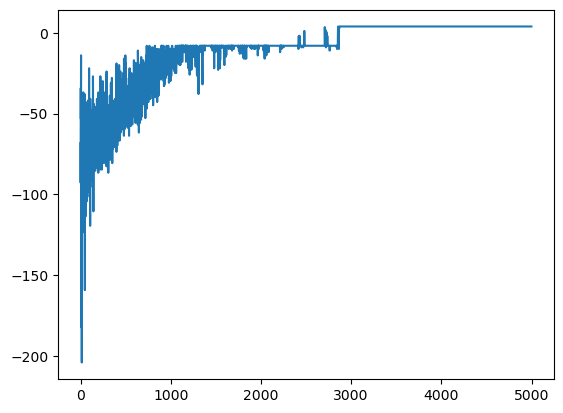

In [39]:
q_learning.plot_rewards()

Starting state is '20'


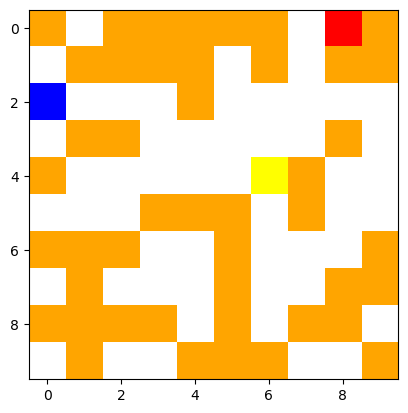

[ 1.24771668  1.24771668 -1.00998501  3.90055104]
3
-0.005


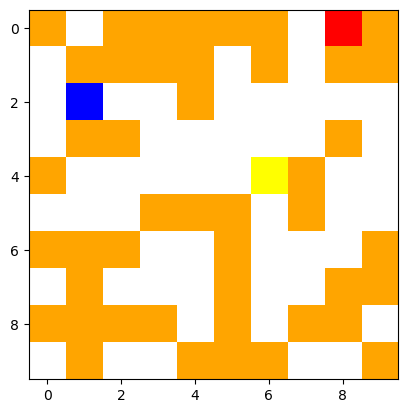

[ 0.43680635 -1.004995    1.25397065  3.9094605 ]
3
-0.005


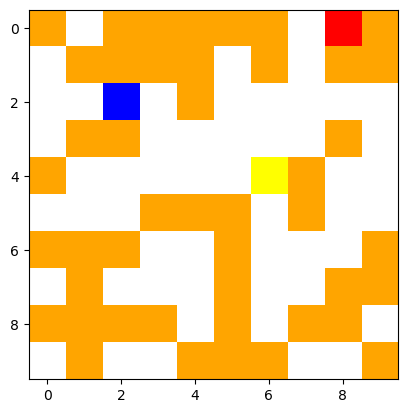

[-1.00998501 -1.00998501  1.26023088  3.91837888]
3
-0.005


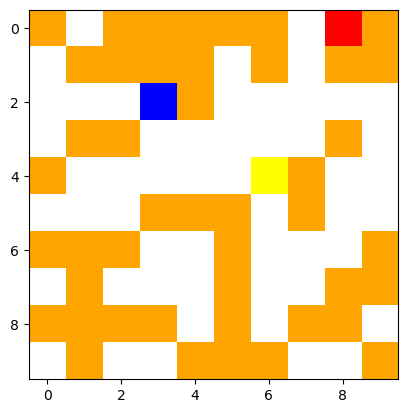

[ 0.79428054  3.92730618  1.26649738 -1.004995  ]
1
-0.005


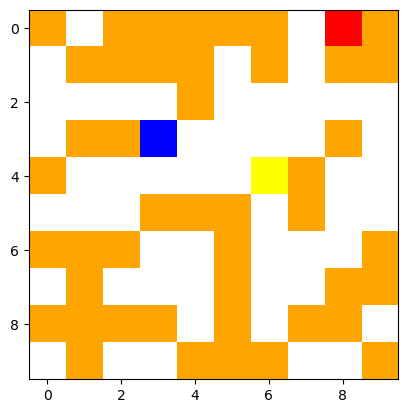

[1.27277015 1.27277015 0.41935231 3.93624243]
3
-0.005


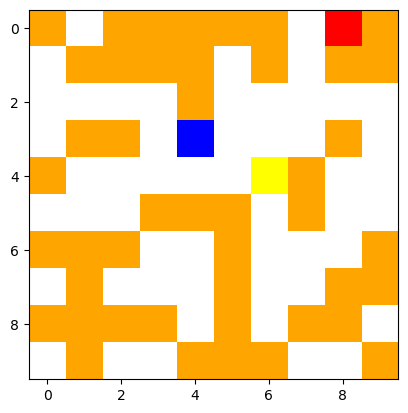

[-1.          3.94518761  1.393153    1.29162616]
1
-0.005


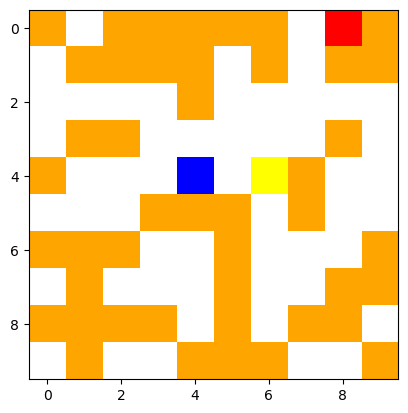

[1.28533453 0.93531416 1.27277015 3.95414176]
3
-0.005


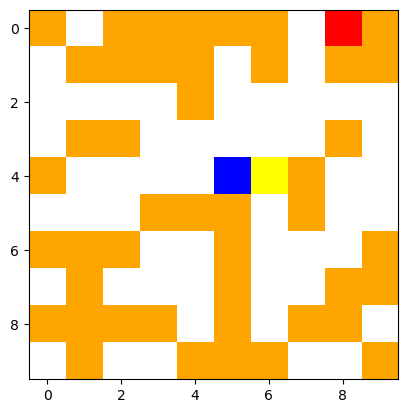

[1.29162616 0.90383793 1.40595851 3.96310486]
3
DING DING DING
2
Coin collected 'False'


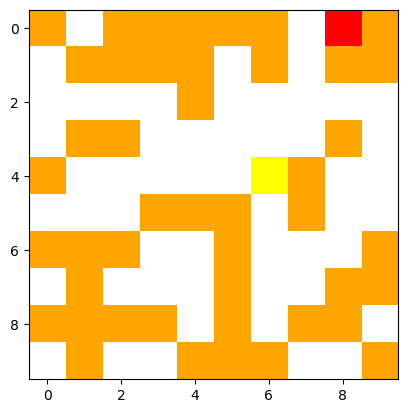

[1.96506993 1.29792408 0.         0.77862474]
0
-0.005


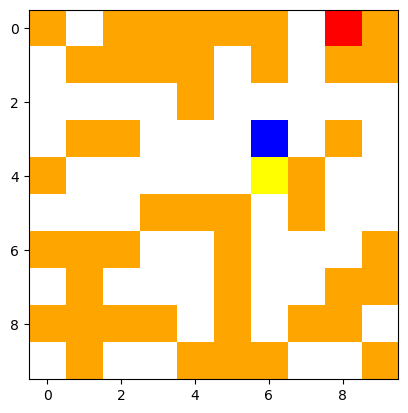

[1.29162616 1.29162616 1.29162616 1.97204197]
3
-0.005


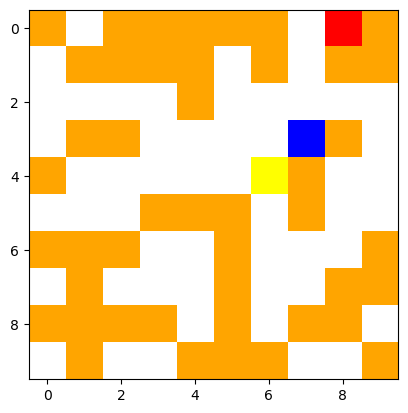

[ 1.97902099 -1.          1.28533453  0.5393425 ]
0
-0.005


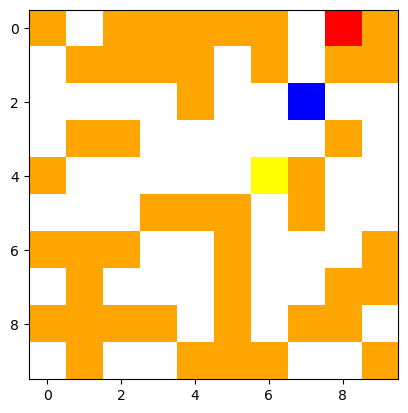

[ 1.986007   1.2790492 -0.005     -0.009995 ]
0
-0.005


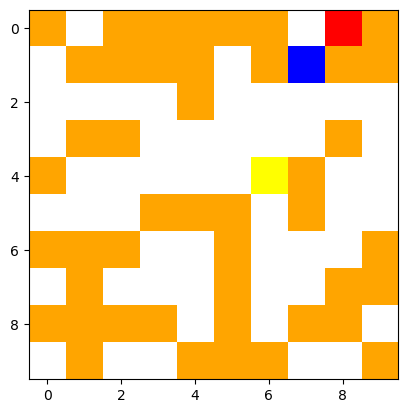

[ 1.993    -0.009995 -1.       -1.      ]
0
-0.005


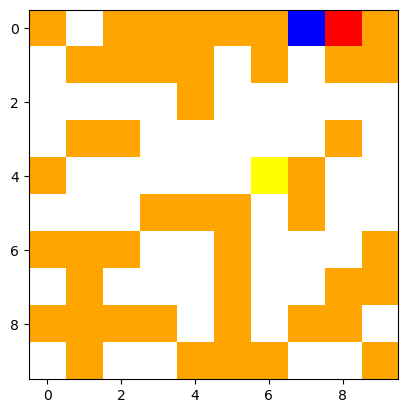

[-1.    -0.005 -1.     2.   ]
3
Reached Target!
(0, 8)
2


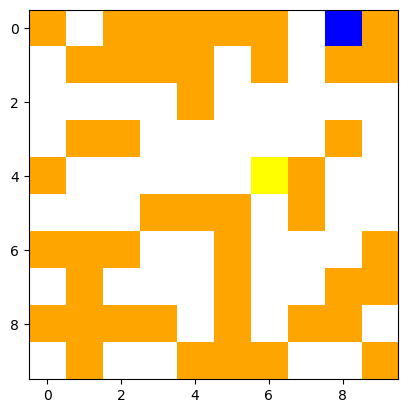

Episode Reward 3.9400000000000004.Q matrix values:
[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-1.  -0.  -1.   2. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.9  1.3  0.9  0.3]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   1.3 -1.   0. ]
 [ 0.   0.   0.   0. ]
 [ 2.  -0.  -1.  -1. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 1.2  1.2 -1.   3.9]
 [ 0.4 -1.   1.3  3.9]
 [-1.  -1.   1.3  3.9]
 [ 0.8  3.9  1.3 -1. ]
 [ 0.   0.   0.   0. ]
 [ 1.3  1.3  0.5  1.3]
 [-1.   1.3  1.3  1.3]
 [ 2.   1.3 -0.  -0. ]
 [-1.  -1.  -0.  -0. ]
 [-1.  -0.  -0.   0. ]
 [ 1.3  0.2  0.9 -1. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 1.3  1.3  0.4  3.9]
 [-1.   3.9  1.4  1.3]
 [ 1.3  9.4  1.3  1.3]
 [ 1.3  1.3  1.3  2. ]
 [ 2.  -1.   1.3  0.5]
 [ 0.   0.   0.   0. ]
 [ 0.  -0.  -1.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0. 

In [40]:
q_learning.test(50)

In [41]:
q_learning.show_Q_spec((5,6))
q_learning.show_Q_spec((3,5))
q_learning.show_Q_spec((4,5))

[1.29162616 1.30422831 0.31553885 0.71287985]
[1.29792408 9.39893913 1.28533453 1.28533453]
[1.29162616 0.90383793 1.40595851 3.96310486]
